# CHRONNOS - automatic coronal hole detection

![](https://github.com/RobertJaro/MultiChannelCHDetection/blob/main/images/title.jpg?raw=true)

This notebook provides coronal hole detections for arbitrary dates. Use the form below to specify the observation date. The data is automatically downloaded from JSOC, afterwards CHRONNOS scans the files and provides the CH maps as FITS files. This version uses only 4 EUV channels for detecting coronal holes. The notebook uses online resources for the computations. You can download the results or continue your evaluation in this notebook.

(Predictions require a few seconds per sample. If you need to detect coronal holes from a larger data set you can activate the GPU acceleration to speed up the detections.)

## Install and imports

In [ ]:
!pip install sunpy==3.1.0
!pip install git+https://github.com/RobertJaro/MultiChannelCHDetection.git@v1.0.0

In [2]:
# imports for download
import os
import shutil
import drms
from datetime import datetime

# CHRONNOS detection tool
from chronnos.evaluate.detect import CHRONNOSDetector
from chronnos.data.convert import get_intersecting_files
from tqdm import tqdm

# visualization
from sunpy.map import Map
from matplotlib import pyplot as plt

# file zip
import gzip
import glob

## Download data

In [4]:
#@title Download Settings
download_dir = 'chronnos_data' #@param {type:"string"}

wavelengths = ['171', '193', '211', '304'] #@param {type:"raw"}

#@markdown Downloading data requires an active registration at JSOC. http://jsoc.stanford.edu/ajax/register_email.html (free of charge)
email = '<<your email>>' #@param {type:"string"}

# initialize the download client and directories
[os.makedirs(os.path.join(download_dir, wl), exist_ok=True) for wl in wavelengths]
client = drms.Client(email=email, verbose=True)

In [5]:
#@title Select observation date
year = 2022 #@param {type:"integer"}
month = 4 #@param {type:"integer"}
day = 26 #@param {type:"integer"}
hour = 12 #@param {type:"integer"}
minute = 0 #@param {type:"number"}

# create datetime object
date = datetime(year, month, day, hour, minute)



We use DRMS to download the specified EUV observations. CHRONNOS-EUV requires the 171, 193, 211 and 304 Angstrom channels. After the download the files are separted by channel, such that the automatic CHRONNOS scan can detect the files.

In [6]:
r = client.export('aia.lev1_euv_12s[%s][%s]{image}' % (date.isoformat('T'), ','.join(wavelengths)), )
r.wait()

downloaded_files = r.download(download_dir)
for f in downloaded_files.download:
    wl = os.path.basename(f).split('.')[3]
    shutil.move(f, os.path.join(download_dir, wl, date.isoformat('T') + '.fits'))


    record: aia.lev1_euv_12s[2022-04-26T11:59:59Z][171]{image_lev1}
  filename: image_lev1.fits
  -> chronnos_data/aia.lev1_euv_12s.20220426T115959Z.171.image_lev1.fits
    record: aia.lev1_euv_12s[2022-04-26T11:59:59Z][193]{image_lev1}
  filename: image_lev1.fits
  -> chronnos_data/aia.lev1_euv_12s.20220426T115959Z.193.image_lev1.fits
    record: aia.lev1_euv_12s[2022-04-26T11:59:59Z][211]{image_lev1}
  filename: image_lev1.fits
  -> chronnos_data/aia.lev1_euv_12s.20220426T115959Z.211.image_lev1.fits
    record: aia.lev1_euv_12s[2022-04-26T11:59:59Z][304]{image_lev1}
  filename: image_lev1.fits
  -> chronnos_data/aia.lev1_euv_12s.20220426T115959Z.304.image_lev1.fits


## Detect coronal holes

The detection tool downloads the specified CHRONNOS model and stores it in your home directory (here we use `chronnos_euv_v1_0.pt`). The first initialization takes a few seconds/minutes (depending on your downlink).

In [7]:
chronnos_detector = CHRONNOSDetector(model_name='chronnos_euv_v1_0.pt')

Next we use the tool to scan a directory for FITS files and detect coronal holes. As result we get a SunPy Map for each observation in the directory. The Map is in binary format, where 1 refers to coronal hole pixels.

The SunPy maps can be reprojected to the original AIA data or used in their pre-processed projection. Either way the coordinate system is fully specified. In this example we use the reprojection.

In [8]:
ch_maps = chronnos_detector.predict_dir(download_dir, dirs=wavelengths, reproject=True)

/usr/local/lib/python3.7/dist-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/usr/local/lib/python3.7/dist-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/usr/local/lib/python3.7/dist-packages/erfa/core.py:155: ErfaWarning: ERFA function "dtf2d" yielded 100 of "dubious year (Note 6)"
  ErfaWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
writing files: 100%|██████████| 1/1 [00:30<00:00, 30.84s/it]


Alterantive you can also use explicitly specify which files to use. For this we use the `predict` method. The input is a list of files per channel (shape: `channel, file`). The order of the channels is `171, 193, 211, 304`.

In [9]:
bn = '%s.fits' % date.isoformat('T')
files = [['chronnos_data/171/' + bn], ['chronnos_data/193/' + bn], ['chronnos_data/211/' + bn], ['chronnos_data/304/' + bn]]
ch_maps = chronnos_detector.predict(files, reproject=True)

writing files: 100%|██████████| 1/1 [00:32<00:00, 32.11s/it]


## Visualize results

In [10]:
ch_map = ch_maps[-1] # select the last Map from the result list

The resulting coronal hole detection can be visualized using the SunPy map.

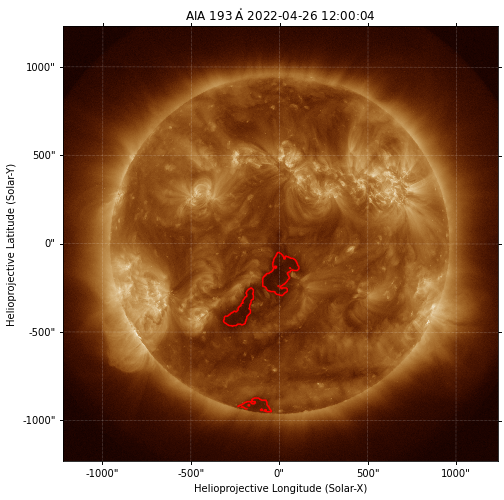

In [11]:
aia_map = Map('chronnos_data/193/%s.fits' % date.isoformat('T'))

plt.figure(figsize=(8, 8))
aia_map.plot()
ch_map.draw_contours(levels=[0.5], colors=['red'])
plt.show()

## Exporting FITS

If you prefer to work with the maps in a different environment (e.g., IDL), you can save the Map as FITS and download the file. (The file directory is in the menu on the left)

In [12]:
ch_map_path = 'chronnos_map.fits'
# we need to convert from bool to int first
Map(ch_map.data.astype('int16'), ch_map.meta).save(ch_map_path)

It is more efficient to gzip the file before downloading. (SunPy can also read Maps as gz files.)

In [13]:
# zip file
with open(ch_map_path, 'rb') as f_in, gzip.open(ch_map_path + '.gz', 'wb') as f_out:
    f_out.writelines(f_in)
os.remove(ch_map_path)
ch_map_path = ch_map_path + '.gz'

## Detect coronal holes from an observation series

A common application is to detect coronal holes from a series of observations. CHRONNOS provides an easy-to-use pipeline to scan through large archives. 

Use the form below to select the dates you want to download. The duration and cadence need to be given in the JSOC syntax (e.g., `d=days, h=hours, m=minutes, s=seconds`).

In [14]:
#@title Select observation series
year = 2022 #@param {type:"integer"}
month = 4 #@param {type:"integer"}
day = 1 #@param {type:"integer"}
hour = 12 #@param {type:"integer"}
minute = 0 #@param {type:"number"}
duration = '30d' #@param {type:"string"}
cadence = '1d' #@param {type:"string"}

# create datetime object
date = datetime(year, month, day, hour, minute)

We store the new data in a separate directory, otherwise we would also scan the previously downloaded files.

In [ ]:
download_dir = 'chronnos_series' #@param {type:"string"}
[os.makedirs(os.path.join(download_dir, wl), exist_ok=True) for wl in wavelengths]


The data download might take a few minutes, depending on the size of the requested series.

In [16]:
r = client.export('aia.lev1_euv_12s[%s/%s@%s][%s]{image}' % (date.isoformat('T'), duration, cadence, ','.join(wavelengths)), )
r.wait()

downloaded_files = r.download(download_dir)
for f in downloaded_files.download:
  path_elements = os.path.basename(f).split('.')
  f_date = path_elements[2]
  wl = path_elements[3]
  shutil.move(f, os.path.join(download_dir, wl, f_date[:-1] + '.fits'))

    record: aia.lev1_euv_12s[2022-04-01T11:59:59Z][171]{image_lev1}
  filename: image_lev1.fits
  -> chronnos_series/aia.lev1_euv_12s.20220401T115959Z.171.image_lev1.fits
    record: aia.lev1_euv_12s[2022-04-01T11:59:59Z][193]{image_lev1}
  filename: image_lev1.fits
  -> chronnos_series/aia.lev1_euv_12s.20220401T115959Z.193.image_lev1.fits
    record: aia.lev1_euv_12s[2022-04-01T11:59:59Z][211]{image_lev1}
  filename: image_lev1.fits
  -> chronnos_series/aia.lev1_euv_12s.20220401T115959Z.211.image_lev1.fits
    record: aia.lev1_euv_12s[2022-04-01T11:59:59Z][304]{image_lev1}
  filename: image_lev1.fits
  -> chronnos_series/aia.lev1_euv_12s.20220401T115959Z.304.image_lev1.fits
    record: aia.lev1_euv_12s[2022-04-02T11:59:59Z][171]{image_lev1}
  filename: image_lev1.fits
  -> chronnos_series/aia.lev1_euv_12s.20220402T115959Z.171.image_lev1.fits
    record: aia.lev1_euv_12s[2022-04-02T11:59:59Z][193]{image_lev1}
  filename: image_lev1.fits
  -> chronnos_series/aia.lev1_euv_12s.20220402T11

### Streaming results

For larger data sets it is better to stream the results. This can be done using the `ipredict` method.

We use CHRONNOS to scan through the downloaded data, where the results are iteratively returned for further processing. We save the SunPy Maps to FITS files and plot quick-view images. 

For detecting coronal holes from a larger number of files, the use of a GPU can significantly speed up the inference. In Colab you can use a GPU by selecting a Hardware Accelerator from the runtime settings (change runtime type; requires a restart).

In [17]:
# create dir for results
os.makedirs(os.path.join(download_dir, 'masks'), exist_ok=True)
os.makedirs(os.path.join(download_dir, 'imgs'), exist_ok=True)
# group FITS files
dirs = ['171', '193', '211', '304']
map_paths = get_intersecting_files(download_dir, dirs=dirs)
# start detection
for ch_map, aia_map_path in tqdm(zip(chronnos_detector.ipredict(map_paths, reproject=False), 
                                     map_paths[1]), 
                                total=len(map_paths[3])):
  # save fits
  Map(ch_map.data.astype('int16'), ch_map.meta).save(os.path.join(download_dir, 'masks', os.path.basename(aia_map_path)))
  # plot overlay (other evaluations can be also done here)
  aia_map = Map(aia_map_path)
  aia_map.plot()
  ch_map.draw_contours(levels=[0.5], colors=['red'])
  plt.savefig(os.path.join(download_dir, 'imgs', '%s.jpg' %ch_map.date.to_datetime().isoformat('T')))
  plt.close()

100%|██████████| 28/28 [05:35<00:00,  5.82s/it]
model prediction: 28it [05:32, 11.87s/it]
100%|██████████| 28/28 [05:35<00:00, 11.98s/it]


In [19]:
# zip files
for mask_path in glob.glob(os.path.join(download_dir, 'masks', '*.fits')):
  with open(mask_path, 'rb') as f_in, gzip.open(mask_path + '.gz', 'wb') as f_out:
      f_out.writelines(f_in)
  os.remove(mask_path)

The results can be found in the menu on the left (select Files and then navigate to the `chronnos_series` directory).

For an easier download we can zip the masks.

In [21]:
shutil.make_archive(os.path.join(download_dir, 'masks'), 'zip', os.path.join(download_dir, 'masks'))

'/content/chronnos_series/masks.zip'